<a href="https://colab.research.google.com/github/AIAerospace/DeepLearning/blob/main/8-CNN/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

### 1. Utilizar un modelo pre-entrenado:

In [1]:
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


image = load_img('perro.jpg', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preparamos la imagen para el modelo y cargamos el modelo
image = preprocess_input(image)
model = VGG16(weights='imagenet', include_top=True)
# predicción
yhat = model.predict(image)           # Probabilidades
label = decode_predictions(yhat)      # Etiquetas
label = label[0][0]

print('%s (%.2f%%)' % (label[1], label[2]*100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Walker_hound (50.12%)


### 2. Feature transfer:

In [2]:
from keras.datasets import cifar10
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(train_data, train_labels), (val_data, val_labels) = cifar10.load_data()

# Normalize pixel values to [0, 1]
train_data = train_data / 255.0
val_data = val_data / 255.0

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=10)
val_labels = to_categorical(val_labels, num_classes=10)

In [5]:
# Build the model using VGG16 as base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)
pretrain_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the pretraining model
pretrain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
# Fit the pretraining model
history_pretrain = pretrain_model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4552 - loss: 1.5548 - val_accuracy: 0.5675 - val_loss: 1.2454
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5591 - loss: 1.2578 - val_accuracy: 0.5696 - val_loss: 1.2066
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5786 - loss: 1.2059 - val_accuracy: 0.5891 - val_loss: 1.1705
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5904 - loss: 1.1586 - val_accuracy: 0.6010 - val_loss: 1.1330
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6032 - loss: 1.1219 - val_accuracy: 0.6011 - val_loss: 1.1318
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6142 - loss: 1.1004 - val_accuracy: 0.6077 - val_loss: 1.1192
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6207 - loss: 1.0748 - val_accuracy: 0.6101 - val_loss: 1.1082
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6305 - loss: 1.0556 -

### 3. Fine tunning:

In [7]:
# Build the model using VGG16 as base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
pretrain_model = Model(inputs=base_model.input, outputs=predictions)
pretrain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Fit the pretraining model
history_pretrain = pretrain_model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

# Freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# Fine-tuning the model
for layer in pretrain_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate
pretrain_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the fine-tuning model
history_finetune = pretrain_model.fit(train_data, train_labels, epochs=5, validation_data=(val_data, val_labels))



Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2152 - loss: 1.9474 - val_accuracy: 0.3787 - val_loss: 1.5053
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4302 - loss: 1.4680 - val_accuracy: 0.5090 - val_loss: 1.2925
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5502 - loss: 1.2171 - val_accuracy: 0.6323 - val_loss: 1.0455
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6652 - loss: 0.9457 - val_accuracy: 0.6778 - val_loss: 0.9525
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7225 - loss: 0.8068 - val_accuracy: 0.7248 - val_loss: 0.8108
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7619 - loss: 0.6996 - val_accuracy: 0.7467 - val_loss: 0.7719
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7993 - loss: 0.5964 - val_accuracy: 0.7306 - val_loss: 0.8946
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8116 - loss: 

313/313 - 1s - 3ms/step - accuracy: 0.7832 - loss: 0.7274
Validation Accuracy: 0.7832
Validation Loss: 0.7274


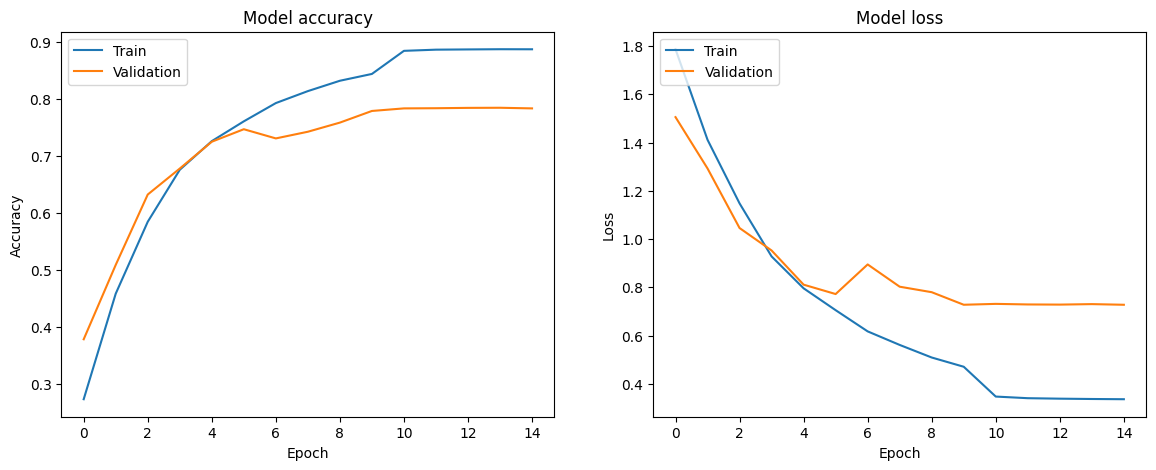

In [9]:
# Evaluate the model on validation data
val_loss, val_accuracy = pretrain_model.evaluate(val_data, val_labels, verbose=2)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_pretrain.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history_pretrain.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_pretrain.history['loss'] + history_finetune.history['loss'])
plt.plot(history_pretrain.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
